# Image to Image

In [2]:
import base64
import io
import json
import os
import sys
import boto3
from PIL import Image

module_path = ".."
sys.path.append(os.path.abspath(module_path))

bedrock_runtime = boto3.client(
    service_name='bedrock-runtime', 
    aws_access_key_id=os.getenv('aws_access_key_id'),
    aws_secret_access_key=os.getenv('aws_secret_access_key'),
    region_name='us-west-2'
)

In [19]:
negative_prompts = [
    "poorly rendered",
    "poor background details",
    "deformed city"
    "poorly drawn futuristic city",
    "disfigured city features",
]
style_preset = "cinematic"
clip_guidance_preset = "FAST_BLUE"
sampler = "K_DPMPP_2S_ANCESTRAL"

In [20]:
def convert_image_to_b64(image_input) -> str:
    if isinstance(image_input, str):
        return handle_file_input(image_input)
    elif isinstance(image_input, Image.Image):
        return handle_pil_input(image_input)
    else:
        raise TypeError(f"Unsupported type: {type(image_input)}")

def handle_file_input(file_path: str) -> str:
    if os.path.exists(file_path):
        print(f"Loading image from: {file_path}")
        with open(file_path, "rb") as file:
            return encode_to_b64(file.read())
    else:
        raise FileNotFoundError(f"No file found at: {file_path}")

def handle_pil_input(pil_image: Image.Image) -> str:
    print("Transforming PIL Image to base64")
    byte_buffer = io.BytesIO()
    pil_image.save(byte_buffer, format="PNG")
    return encode_to_b64(byte_buffer.getvalue())

def encode_to_b64(byte_data: bytes) -> str:
    return base64.b64encode(byte_data).decode("utf-8")

image_1 = Image.open('data/image_1.png')
encoded_image_b64 = convert_image_to_b64(image_1)
print(encoded_image_b64[:80] + "...")

Transforming PIL Image to base64
iVBORw0KGgoAAAANSUhEUgAAAwAAAAQACAIAAADZRKlXAAEAAElEQVR4nIz925IjR7IsCqqaewDIquK1...


In [21]:
new_change_prompt = "add more futuristic elements such as futuristic vehicles"

In [22]:
def construct_request_payload(
        alteration_prompt, 
        negative_prompts_list, 
        initial_image_b64, 
        preset_style, 
        preset_clip_guidance, 
        sampler_type
    ):
    
    payload = {
        "prompt": alteration_prompt,
        "mode": 'image-to-image',
        "strength": 0.9,
        "image": initial_image_b64,
        "seed": 321,
    }
    
    return json.dumps(payload)

def invoke_model(runtime, payload, model_identifier):
    response = runtime.invoke_model(body=payload, modelId=model_identifier)
    return json.loads(response.get("body").read())

request_payload = construct_request_payload(
    new_change_prompt, negative_prompts, encoded_image_b64, style_preset, clip_guidance_preset, sampler
)

model_identifier = "stability.sd3-5-large-v1:0"
bedrock_response = invoke_model(bedrock_runtime, request_payload, model_identifier)
image_base64_string = bedrock_response["images"][0]
print(f"{image_base64_string[:80]}...")

os.makedirs("data", exist_ok=True)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYG...


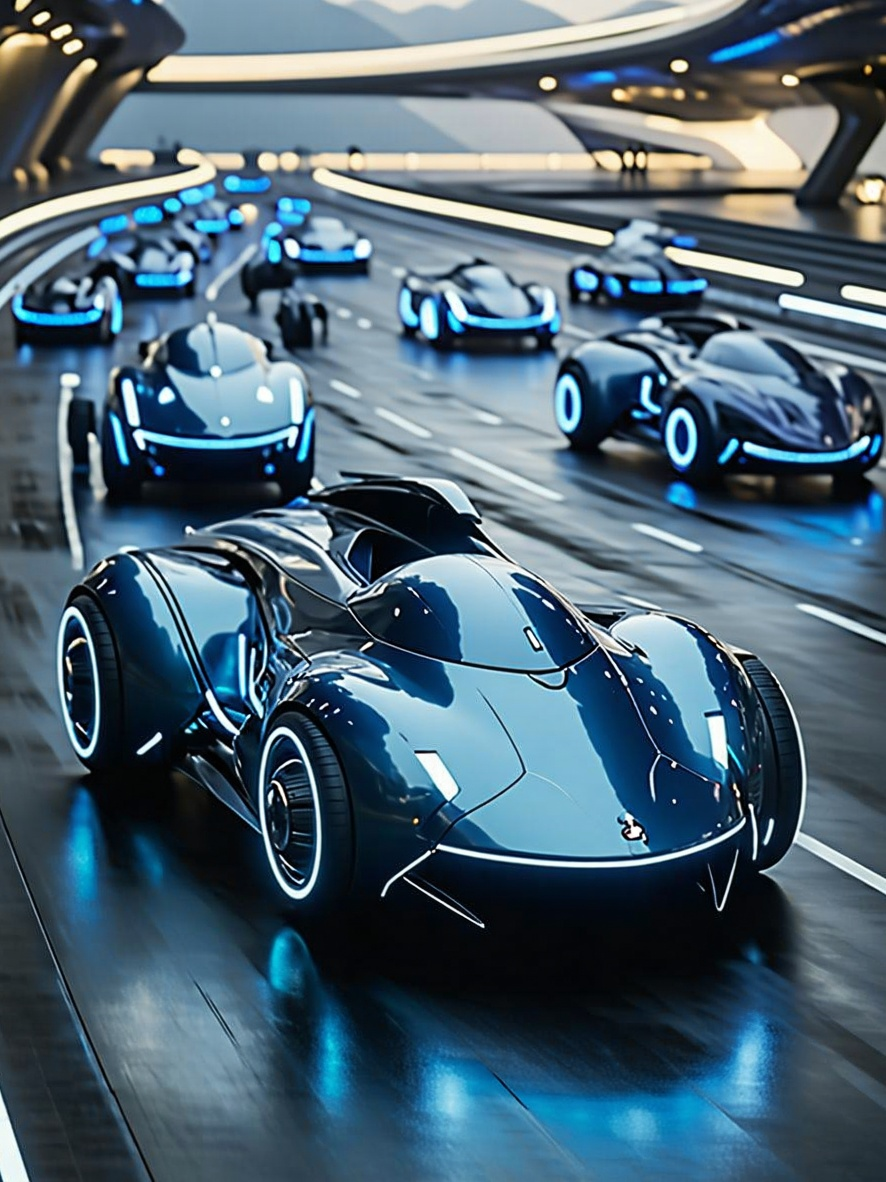

In [23]:
image_2 = Image.open(io.BytesIO(base64.decodebytes(bytes(image_base64_string, "utf-8"))))
image_2.save("data/image_2.png")
image_2

# Image Inpainting

In [66]:
os.makedirs("output", exist_ok=True) #A
new_img = Image.open('data/image_3.png') #B
binary_mask = Image.open('output/binary_mask.png')
new_img.show() #C

In [67]:
inpaint_text = "integrate sky elements"

In [70]:
def image_to_base64(img):
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8") #A

inpaint_request = json.dumps({
    "taskType": "INPAINTING",
    "inPaintingParams": {
        "text": inpaint_text,
        "image": image_to_base64(mask_img),
        "maskImage": image_to_base64(binary_mask)
    },
    "imageGenerationConfig": {
        "quality": "standard",
        "numberOfImages": 1,
        "height": 512,
        "width": 512,
        "cfgScale": 10
    }
})

model_identifier = "amazon.titan-image-generator-v2:0"

AttributeError: 'numpy.ndarray' object has no attribute 'save'

In [60]:
response = bedrock_runtime.invoke_model(body=inpaint_request, modelId=model_identifier) #A
response_content = json.loads(response.get("body").read()) #B



In [61]:
inpainted_image_base64_string = bedrock_response["images"][0]
print(f"{image_base64_string[:80]}...")

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYG...


In [62]:
inpaint_image = Image.open(io.BytesIO(base64.b64decode(bytes(inpainted_image_base64_string, "utf-8"))))
inpaint_image.save("output/inpainted_image.png")
inpaint_image.show()